In [57]:
%matplotlib inline

from IPython.display import display as d
from IPython.display import Image

import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, length, sum as _sum, regexp_replace

def save_fig(ax, title, pdfname):
    ax.set_title(title)
    ax.get_figure().savefig(pdfname, bbox_inches="tight", dpi=300)

In [58]:
# Used dataset: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset
df = pd.read_csv("amazon_sales.csv")
d(df)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,₹379,₹919,59%,4,"1,090",SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,"₹2,280","₹3,045",25%,4.1,"4,118","230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the me

In [59]:
# extract contents of reviews to text file for further processing with Hadoop
review_contents = []

for review_content in df["review_content"].dropna():
    review_contents.extend(review_content.split(','))

review_contents = [review.strip() for review in review_contents if review.strip()]

with open("review_contents.txt", "w", encoding="utf-8") as f:
    f.write('\n'.join(review_contents))

In [60]:
# extract contents of titles of reviews to text file for further processing with Hadoop
review_titles = []

for review_title in df["review_title"].dropna():
    review_titles.extend(review_title.split(','))

review_titles = [review.strip() for review in review_titles if review.strip()]

with open("review_titles.txt", "w", encoding="utf-8") as f:
    f.write('\n'.join(review_titles))

In [61]:
# Hadooop cmds used
# hdfs dfs -put C:\Users\alfa\Downloads\amazon_sales /amazon_sales_input
# hdfs dfs -ls /amazon_sales_input
# hadoop jar C:\hadoop-3.3.4\share\hadoop\mapreduce\hadoop-mapreduce-examples-3.3.4.jar wordcount /amazon_sales_input/ /amazon_sales_output
# hdfs dfs -get /amazon_sales_output/part-r-00000 C:\Users\alfa\Downloads

In [62]:
# Further analyze output of Hadoop with Spark
spark = SparkSession.builder.appName("AmazonSalesAnalysis").getOrCreate()
df = spark.read.option("delimiter", "\t").option("inferSchema", "true").csv("part-r-00000")
df = df.withColumnRenamed("_c0", "word").withColumnRenamed("_c1", "count")
df = df.sort("count", ascending=False)
df.show(truncate=False)

+-------+-----+
|word   |count|
+-------+-----+
|the    |12232|
|is     |10688|
|and    |9964 |
|to     |8354 |
|for    |7684 |
|it     |6338 |
|a      |6244 |
|I      |5438 |
|good   |5053 |
|of     |4758 |
|product|4571 |
|this   |4227 |
|in     |4222 |
|Good   |4205 |
|with   |3492 |
|not    |3436 |
|but    |3273 |
|quality|2411 |
|you    |2404 |
|on     |2381 |
+-------+-----+
only showing top 20 rows


# Get top 20 nouns - Solution 1: stopword-list-based (works better)

In [63]:
# Initial version of stopword list taken from https://raw.githubusercontent.com/stopwords-iso/stopwords-en/refs/heads/master/stopwords-en.txt
with open("stopwords-en.txt", "r", encoding="utf-8") as f:
    stopwords = [line.strip().lower() for line in f if line.strip()]

df_nouns = (
    df.withColumn("word", regexp_replace(lower(col("word")), r"\W+$", ""))
      .filter(~col("word").isin(stopwords))
      .filter(length(col("word")) >= 4)
      .groupBy(col("word").alias("word"))
      .agg(_sum("count").alias("count"))
      .orderBy(col("count").desc())
      .limit(20)
)

df_nouns.show(truncate=False)

+-------+-----+
|word   |count|
+-------+-----+
|product|6195 |
|quality|3069 |
|price  |1795 |
|cable  |1664 |
|money  |1250 |
|phone  |1174 |
|battery|902  |
|time   |863  |
|watch  |837  |
|sound  |825  |
|worth  |744  |
|fine   |615  |
|amazon |543  |
|water  |535  |
|camera |526  |
|range  |504  |
|power  |497  |
|screen |475  |
|speed  |457  |
|budget |448  |
+-------+-----+



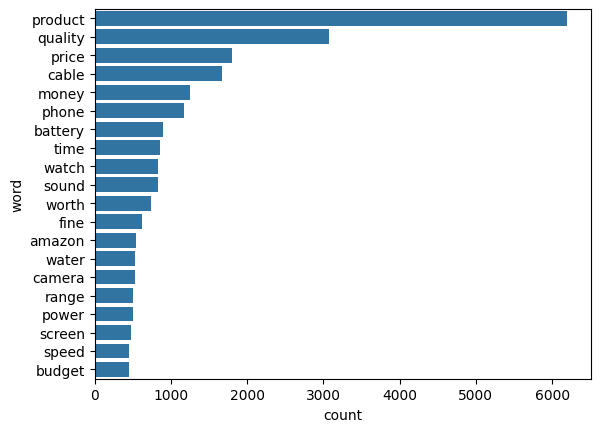

In [64]:
top_nouns_df = pd.DataFrame(df_nouns.collect(), columns=["word", "count"])
top_nouns_df = top_nouns_df.sort_values(by="count", ascending=False)

ax = sns.barplot(data=top_nouns_df, x="count", y="word")
plt.show()
# save_fig(ax, "", "barplot_top20_nouns_stopword.png")
plt.close()

# Output required for Aufgabe 3
top_nouns_df.to_csv("top_nouns_df.csv", index=False)

# Get top 20 nouns - Solution 2: nltk-based

In [65]:
# !pip install nltk
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt")

nouns_only = [
    (word, count)
    for word, count in df.collect()
    if word is not None and count is not None and pos_tag([word])[0][1].startswith("NN")
]
top_nouns = sorted(nouns_only, key=lambda x: x[1], reverse=True)[:40]
d("Top 40 nouns:")
for word, count in top_nouns:
    print(f"{word}: {count}")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sfremerey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sfremerey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'Top 40 nouns:'

product: 4571
quality: 2411
use: 1598
price: 1410
cable: 1378
Nice: 1149
i: 1038
it's: 980
money: 932
phone: 921
Product: 758
time: 705
watch: 704
It's: 687
battery: 673
product.: 623
good.: 612
sound: 594
works: 579
Value: 577
fast: 559
it.: 464
water: 461
don't: 452
need: 433
TV: 432
bit: 427
work: 424
worth: 420
power: 418
fine: 416
value: 399
camera: 398
screen: 381
range: 361
Quality: 357
bought: 352
months: 351
speed: 348
looks: 345


,word,count
20,product,5329
22,quality,2768
10,it's,1667
29,use,1598
19,price,1410
3,cable,1378
16,nice,1149
9,i,1038
30,value,976
13,money,932


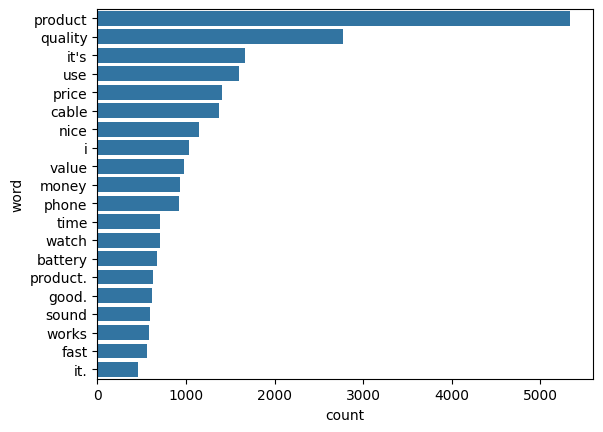

In [66]:
# Get top 20 nouns
top_nouns_df = pd.DataFrame(top_nouns, columns=["word", "count"])
top_nouns_df["word"] = top_nouns_df["word"].str.lower()
top_nouns_df = top_nouns_df.groupby("word", as_index=False)["count"].sum()
top_nouns_df = top_nouns_df.sort_values(by="count", ascending=False)

top_20_nouns_df = top_nouns_df.head(20)

d(top_20_nouns_df)
ax = sns.barplot(data=top_20_nouns_df, x="count", y="word")
plt.show()
# save_fig(ax, "", "barplot_top20_nouns_nltk.png")
plt.close()

In [67]:
spark.stop()